In [29]:
# NOTES on installing modules!!!
# - You should install pandas again using current active python interpreter. 
# - For example if your current interpreter is located in:
# - ~\AppData\Local\Microsoft\WindowsApps\python3.11.exe
# - then you should install pandas using this command:
# - ~\AppData\Local\Microsoft\WindowsApps\python3.11.exe -m pip install pandas

In [30]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import os
import pickle


In [31]:
# get df and remove unnecessary columns
relative_data_file_path = "./nasa.csv"

df = pd.read_csv(relative_data_file_path)

# Used df.types to find all non numerical columns
# Close Approach Date              object - DROP
# Orbiting Body                    object - DROP
# Orbit Determination Date         object - DROP
# Equinox                          object - DROP

# can also get rid of some based on domain knowledge:
# Neo Reference ID                  int64 - DROP
# Name                              int64 - DROP
# Est Dia in KM, Miles, and Feet (so columns 5, 6, 7, 8, 9, 10 of df) - DROP
# Relative Velocity km per sec    float64 - DROP
# Miles per hour                  float64 - DROP
# Miss Dist.(Astronomical)        float64 - DROP
# Miss Dist.(lunar)               float64 - DROP
# Miss Dist.(miles)               float64 - DROP
# Orbit ID                          int64 - DROP

non_numerical_columns = ["Close Approach Date", "Orbiting Body", "Orbit Determination Date", "Equinox"]
domain_knowledge_drops = ["Neo Reference ID", "Name",
                          "Est Dia in KM(min)", "Est Dia in KM(max)", 
                          "Est Dia in Miles(min)", "Est Dia in Miles(max)", 
                          "Est Dia in Feet(min)", "Est Dia in Feet(max)",
                          "Relative Velocity km per sec", "Miles per hour",
                          "Miss Dist.(Astronomical)", "Miss Dist.(lunar)",
                          "Miss Dist.(miles)", "Orbit ID"]

cols_to_drop = non_numerical_columns + domain_knowledge_drops

clean_df = df.drop(columns=cols_to_drop)

clean_df.head()

,Absolute Magnitude,Est Dia in M(min),Est Dia in M(max),Epoch Date Close Approach,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,127.219879,284.472297,788947200000,22017.003799,62753692.0,5,0.025282,4.634,2458000.5,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.3,146.067964,326.617897,788947200000,65210.346095,57298148.0,3,0.186935,5.457,2458000.5,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.3,231.502122,517.654482,789552000000,27326.560182,7622911.5,0,0.043058,4.557,2458000.5,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.4,8.801465,19.680675,790156800000,40225.948191,42683616.0,6,0.005512,5.093,2458000.5,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.6,127.219879,284.472297,790156800000,35426.991794,61010824.0,1,0.034798,5.154,2458000.5,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


In [45]:
# know that all elements are numerical and have 2+ unique elements
# Want to pick features that have highest correlation with variance

print("Correlation:")
print(clean_df.corr()['Hazardous'].sort_values())

Correlation:
Orbit Uncertainity            -0.328721
Absolute Magnitude            -0.325522
Minimum Orbit Intersection    -0.288949
Perihelion Distance           -0.207027
Epoch Date Close Approach     -0.079020
Orbital Period                -0.011168
Semi Major Axis               -0.010770
Perihelion Arg                -0.003865
Jupiter Tisserand Invariant   -0.003404
Inclination                    0.009607
Mean Motion                    0.013028
Asc Node Longitude             0.017536
Miss Dist.(kilometers)         0.032407
Perihelion Time                0.038113
Aphelion Dist                  0.040800
Epoch Osculation               0.040940
Mean Anomaly                   0.054164
Est Dia in M(max)              0.132424
Est Dia in M(min)              0.132424
Eccentricity                   0.183269
Relative Velocity km per hr    0.191970
Hazardous                      1.000000
Name: Hazardous, dtype: float64


In [96]:
# To maximize variance and minimize correlation: Loop over all features,
# only keep features in the top 11 for correlation and variance
num_values_to_check = 6

# get the top num_values_to_check features for variance and correlation
top_corr = abs(clean_df.corr()['Hazardous']).sort_values()[-num_values_to_check-1:]
top_corr = top_corr.drop(labels=['Hazardous'])

top_cols = list(top_corr.index)

print("Best features")
top_cols.sort()
print(np.asarray(top_cols))

X = clean_df[top_cols]
y = clean_df['Hazardous']

Best features
['Absolute Magnitude' 'Eccentricity' 'Minimum Orbit Intersection'
 'Orbit Uncertainity' 'Perihelion Distance' 'Relative Velocity km per hr']


C:\Users\benha\AppData\Local\Temp\ipykernel_11996\759567346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_cols_df.loc[:,'Hazardous'] = clean_df['Hazardous']


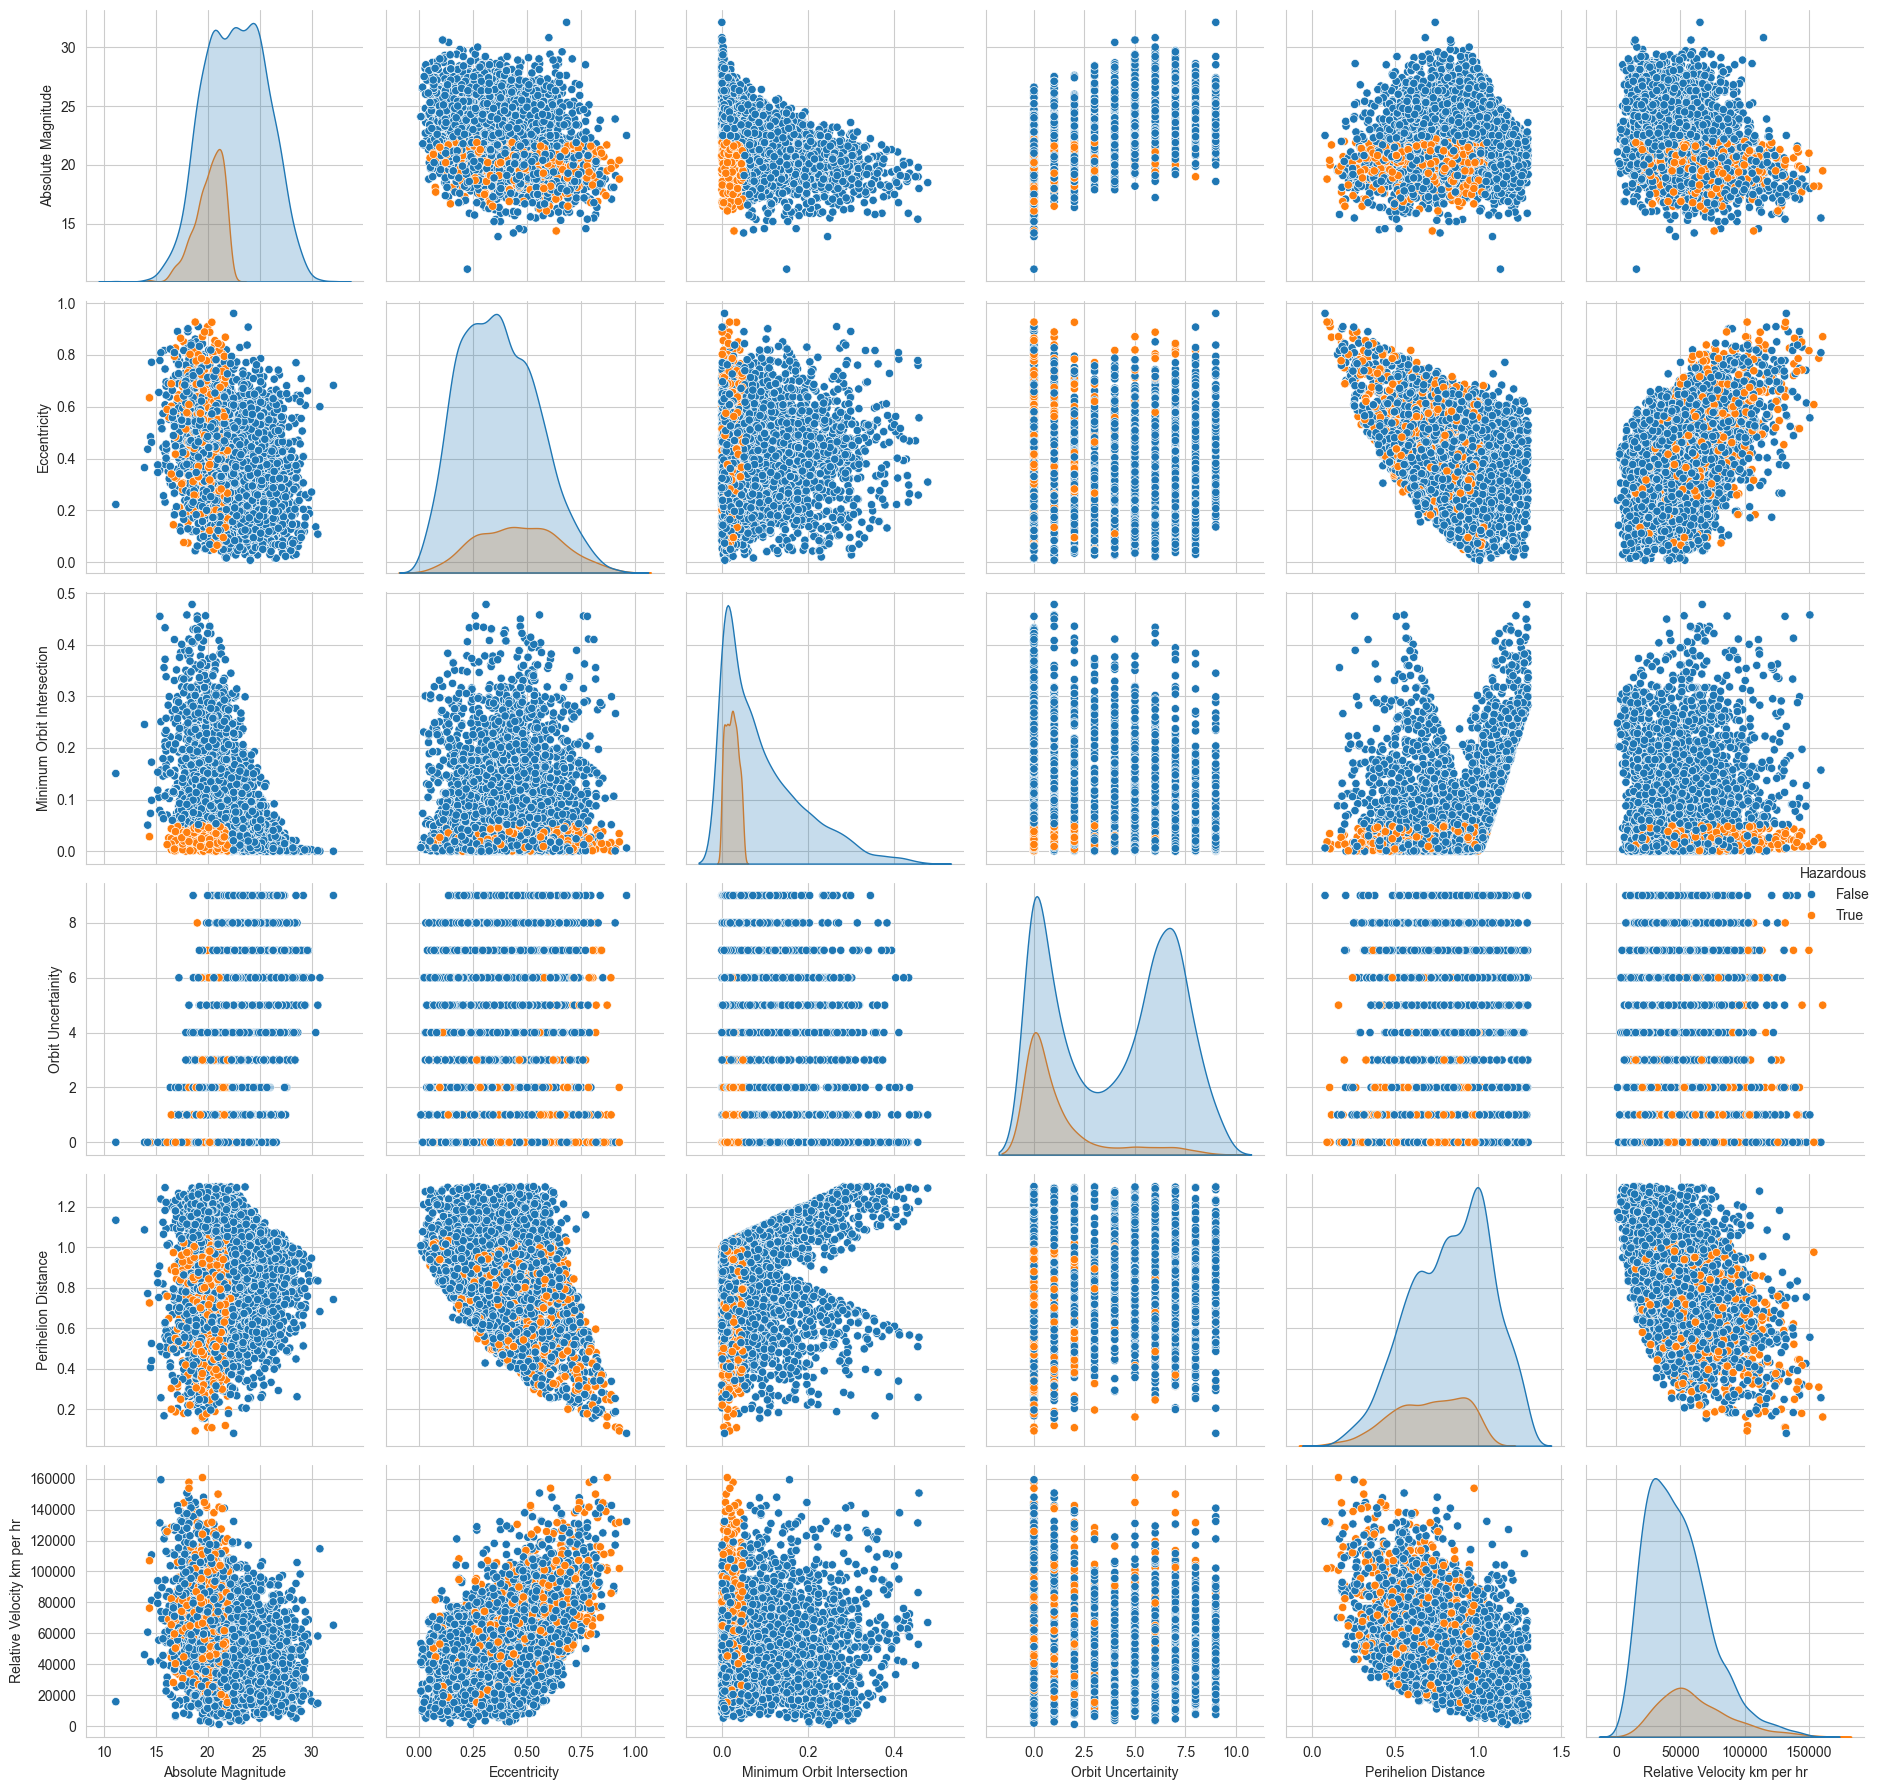

In [34]:
# plot top columns 
top_cols_df = clean_df[top_cols]
top_cols_df.loc[:,'Hazardous'] = clean_df['Hazardous']

sns.set_style("whitegrid")
sns.pairplot(top_cols_df, hue="Hazardous", height=3)
plt.tight_layout()
plt.show()

In [105]:
# NOTE: The best way to split the data is such that y_test contains a very similar ratio of hazardous:non_hazardous
# to the clean_df. Until that happens, keep testing different random_state values
# so if the ratio in y_test is within 0.2 of the ratio in scaled_df, we should be good

# THIS CODE IS ONLY USED TO FIND THE BEST RANDOM_STATE PARAMETER FOR THE RATIO REQUIREMENTS.

# figure out clean_df ratio
num_non_hazardous = clean_df["Hazardous"].value_counts().iloc[0]
num_hazardous = clean_df["Hazardous"].value_counts().iloc[1]
hazardous_ratio = num_hazardous / num_non_hazardous
print(f"Cleaned_df ratio: {hazardous_ratio}")

# want to find what random_state variable would give
# the smallest difference between the scaled_df ratio
# of hazardous to non-hazardous and the y_test ratio
smallest_ratio_diff = 0.2
ERROR = 1e-6 # grant some error so as to not get repeating values
best_random_state = 0 # save the best random_state value

# Attempt train_test_split until the ratio is close enough
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i, shuffle=True)

    y_non_hazardous = y_test.value_counts().iloc[0]
    y_hazardous = y_test.value_counts().iloc[1]
    y_ratio = y_hazardous / y_non_hazardous
    if abs(hazardous_ratio - y_ratio) <= smallest_ratio_diff - ERROR:
        print(f"random_state = {i}: ratio_diff = {abs(hazardous_ratio - y_ratio)}")
        smallest_ratio_diff = abs(hazardous_ratio - y_ratio)
        best_random_state = i
        # NOTE: Mathematically, if y_test has a very similar ratio to clean_df,
        # then y_train would also have to have a very similar ratio to clean_df


Cleaned_df ratio: 0.1920142421159715
random_state = 0: ratio_diff = 0.009164305167673914
random_state = 1: ratio_diff = 0.009010085668919643
random_state = 2: ratio_diff = 0.004414329312599913
random_state = 3: ratio_diff = 0.0031676007978473086
random_state = 6: ratio_diff = 0.0016589121667329454
random_state = 8: ratio_diff = 0.00014638951114304133


In [236]:
# Actually split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=True)
# so this is silly... splitting the model by the correct ratio leads to a slightly worse model
# than by just using random_state = 17... discuss with group on Thursday!

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [237]:
# scale X's
scaler = MinMaxScaler() # initialize scaler

X_train_scaled = scaler.fit_transform(X_train) # fit transform to prepare scaler
X_test_scaled = scaler.transform(X_test) # just fit to not impede model training

# convert to dfs
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

Best accuracies reached by each model:
- KNN: k = 7, training acc = 0.9562899786780383
- DTC: depth = 5, 0.997867803837953
- logreg: 0.9264392324093816


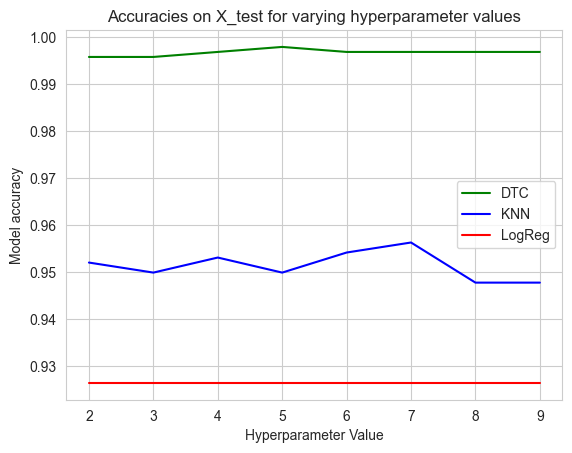

In [238]:
# create a code that'll experiment with various models and hyperparameters
# Assume smallest hyperparameter is 2 and largest is 100
min_hyperparam = 2
max_hyperparam = 10

knn_accs = []
dtc_accs = []

# Simply test out a LogisticRegression model, as it takes
# no hyperparameters and would thus be nonsensical in the loop
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
logreg_pred = logreg.predict(X_test_scaled)
logreg_acc = accuracy_score(y_pred=logreg_pred, y_true=y_test)
# Create a list of just the single logistic regression accuracy
# so it can be plotted alongside KNN and DTC
logreg_accs = [logreg_acc for _ in range(min_hyperparam, max_hyperparam)]

for i in range(min_hyperparam, max_hyperparam):
    knn = KNeighborsClassifier(n_neighbors=i)
    dtc = DecisionTreeClassifier(max_depth=i)

    knn.fit(X_train_scaled, y_train)
    dtc.fit(X_train_scaled, y_train)

    knn_pred = knn.predict(X_test_scaled)
    dtc_pred = dtc.predict(X_test_scaled)

    knn_accs.append(accuracy_score(y_pred=knn_pred, y_true=y_test))
    dtc_accs.append(accuracy_score(y_pred=dtc_pred, y_true=y_test))

# plot accuracies for varying input parameters

# setting up the x-axis
hyperparam_vals = [i for i in range(min_hyperparam, max_hyperparam)]

plt.plot(hyperparam_vals, dtc_accs, color="green", label='DTC')
plt.plot(hyperparam_vals, knn_accs, color="blue", label='KNN')
plt.plot(hyperparam_vals, logreg_accs, color="red", label='LogReg')
plt.legend()
plt.title("Accuracies on X_test for varying hyperparameter values")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Model accuracy")

print("Best accuracies reached by each model:")
# NOTE: Since our first hyperparam is "2", we have k=2 at index 0, for example. So must add
# + 2 to index to find the hyperparam
print(f"- KNN: k = {knn_accs.index(max(knn_accs)) + 2}, training acc = {max(knn_accs)}")
print(f"- DTC: depth = {dtc_accs.index(max(dtc_accs)) + 2}, {max(dtc_accs)}")
print(f"- logreg: {max(logreg_accs)}")

Accuracy = 0.997867803837953
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       793
        True       1.00      0.99      0.99       145

    accuracy                           1.00       938
   macro avg       1.00      0.99      1.00       938
weighted avg       1.00      1.00      1.00       938



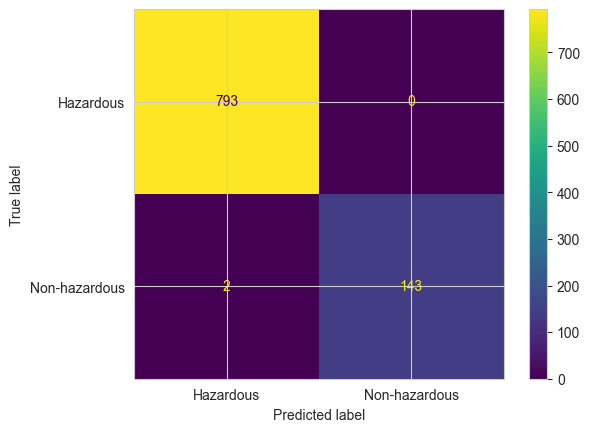

In [239]:
# based on above code, dtc with depth = 5 works best

# create the model
model = DecisionTreeClassifier(max_depth=dtc_accs.index(max(dtc_accs)) + 2)

# train
model.fit(X_train_scaled, y_train)

# test
y_pred = model.predict(X_test_scaled)

# accuracy and classification report
print(f"Accuracy = {accuracy_score(y_pred=y_pred, y_true=y_test)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hazardous", "Non-hazardous"]).plot()

In [138]:
# In order to attempt to find an even better model:
# this cell of code will iterate through all the parameters of
# an RFC, using the RandomizedSearchCV algorithm to find
# the best parameters for the asteroid classification problem.

# Random forest classifier
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train_scaled, y_train)

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 293}


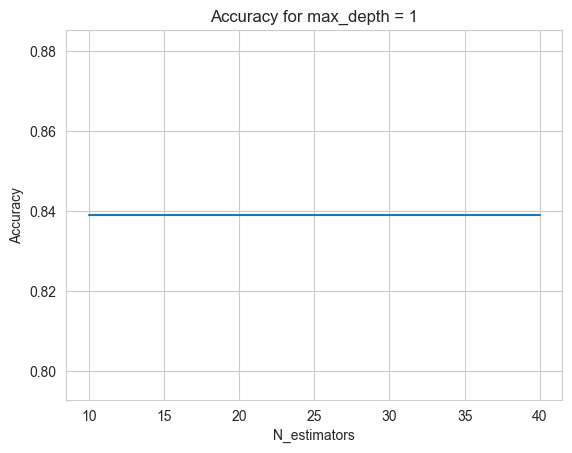

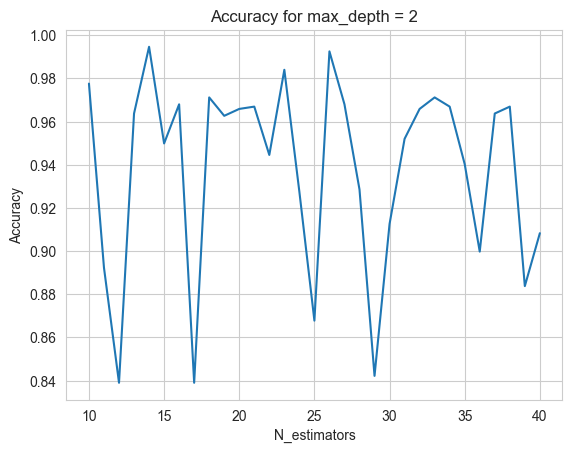

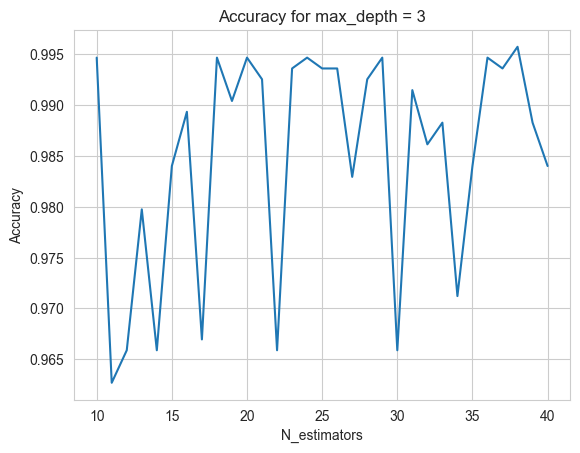

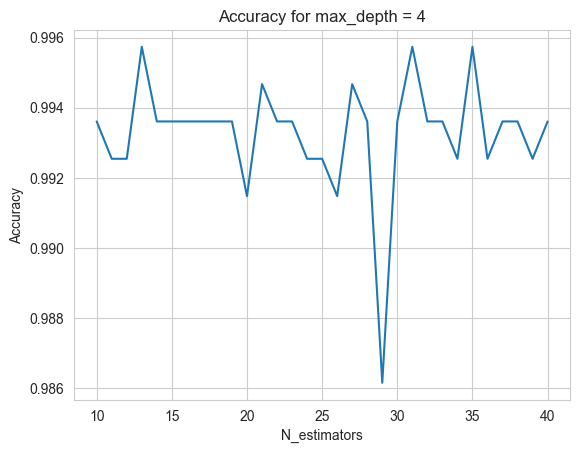

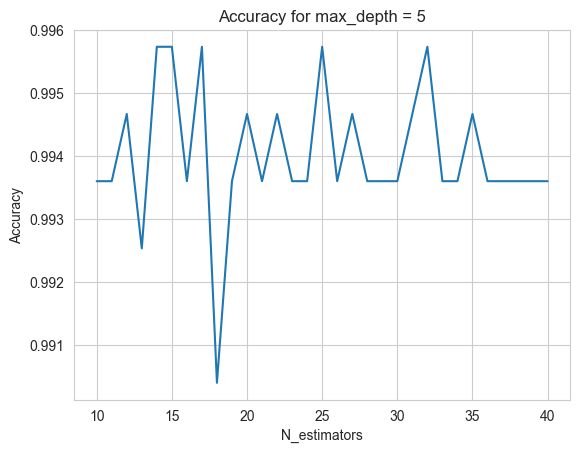

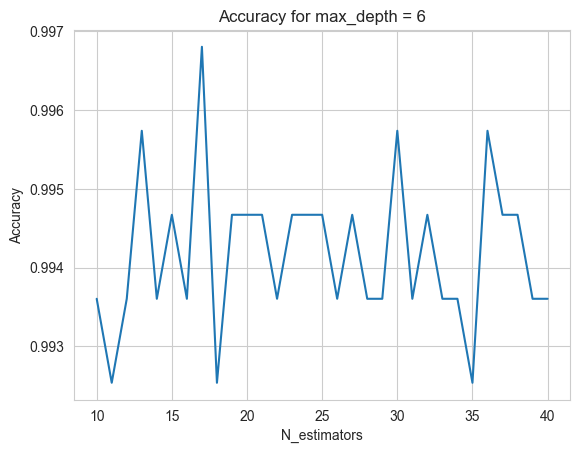

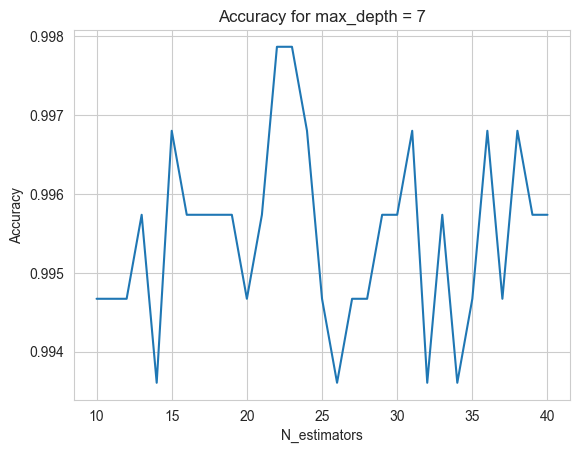

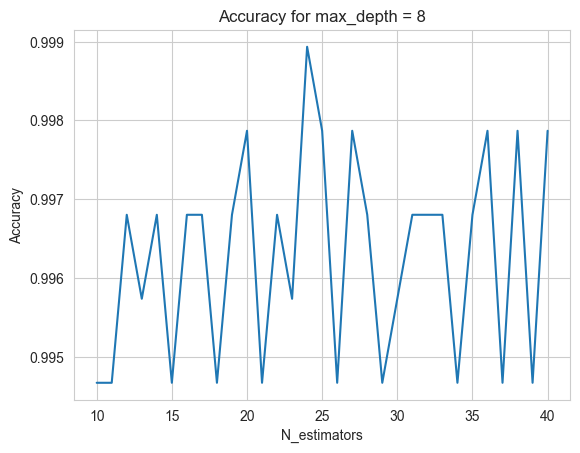

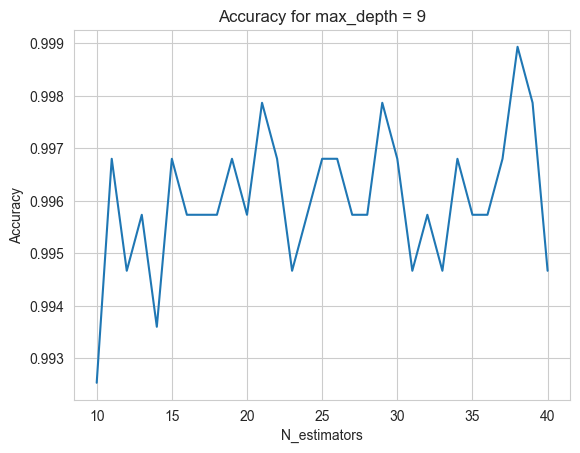

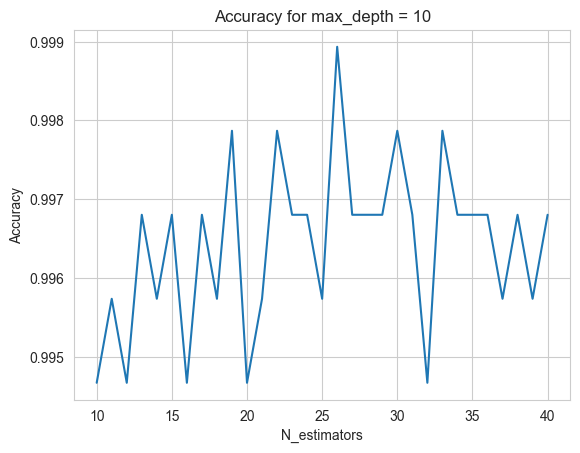

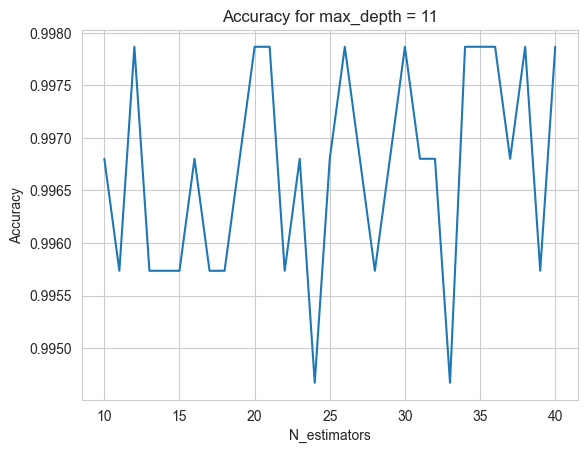

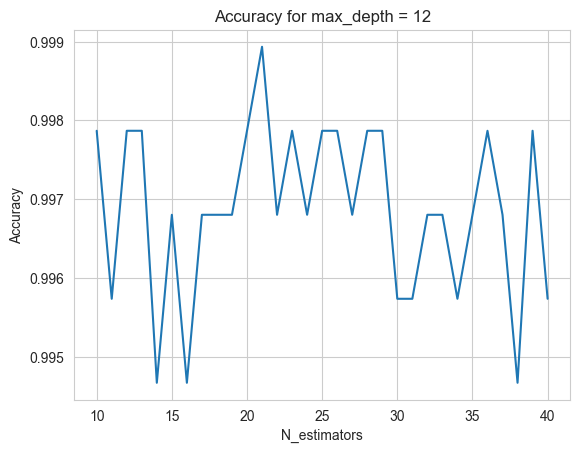

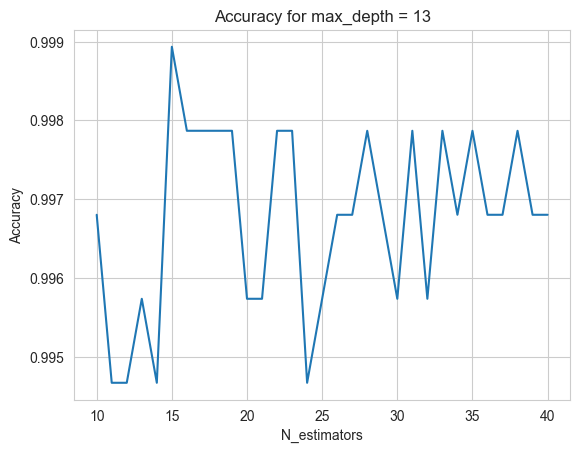

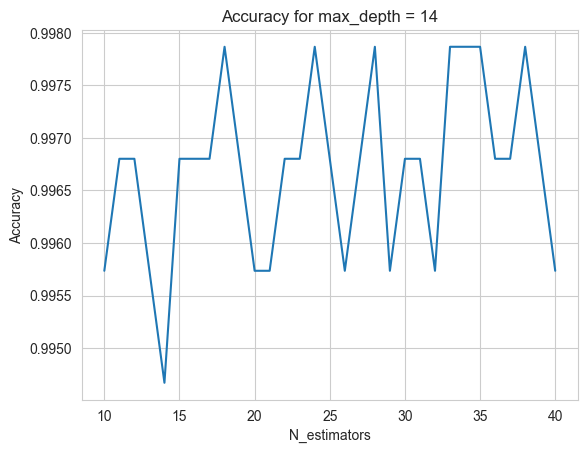

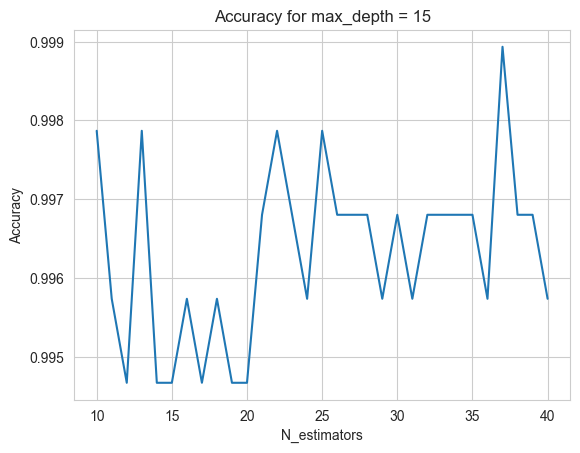

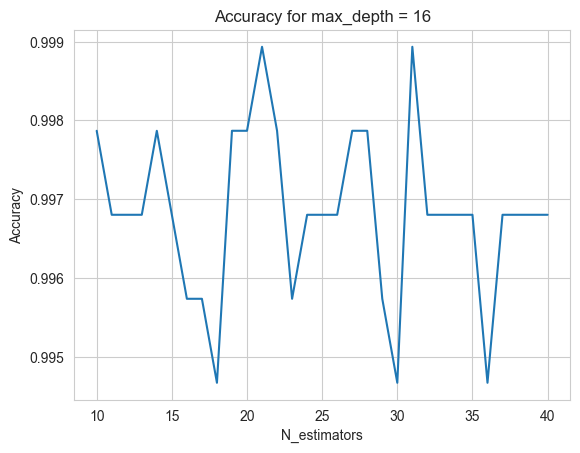

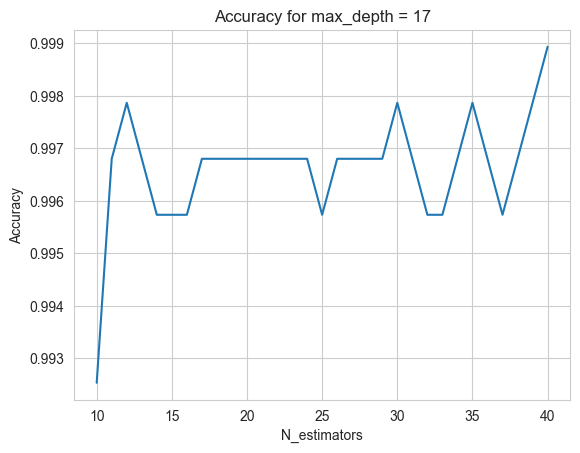

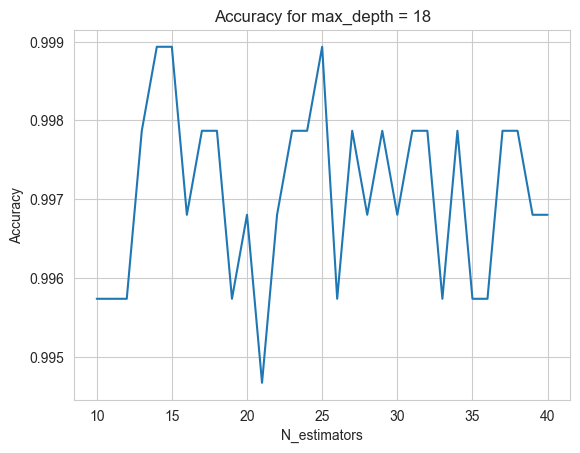

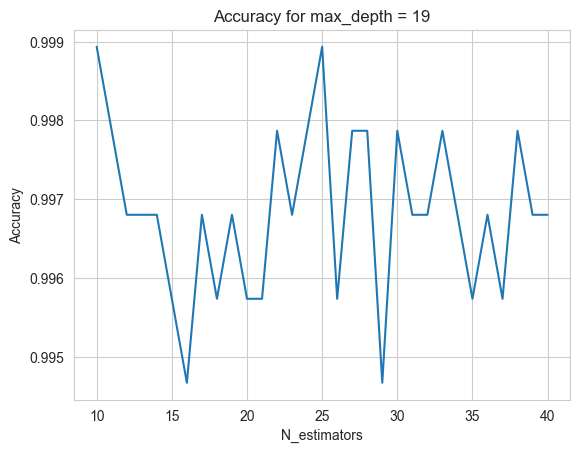

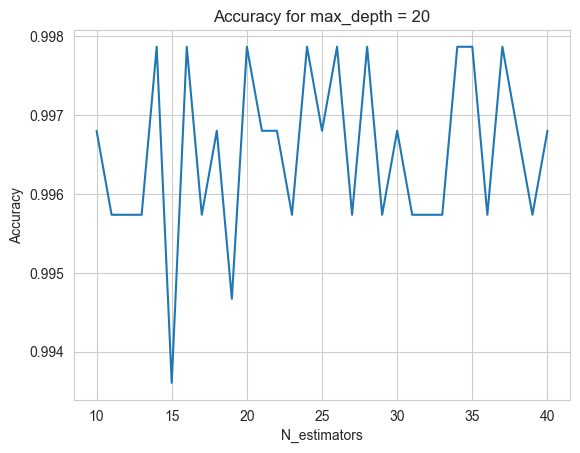

BEST RF MODEL: 0.9989339019189766
N_estimators = 25
Max_depth: 19


In [153]:
# find best hyperparams for RFC
n_estimators_range = (10, 40)
max_depth_range = (2, 20)

rf_accs = []

best_acc_reached = 0
best_acc_n_estimators = 0
best_acc_max_depth = 0
ERROR = 1e-6

for max_depth in range(max_depth_range[0], max_depth_range[1] + 1):
    max_depth_accs = []
    for n_estimators in range(n_estimators_range[0], n_estimators_range[1] + 1):
        # Create a model with these parameters
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

        # train model
        rf.fit(X_train_scaled, y_train)

        # test
        y_pred = rf.predict(X_test_scaled)

        # save the accuracy
        acc = accuracy_score(y_true=y_test, y_pred=y_pred)
        max_depth_accs.append(acc)
        if acc >= best_acc_reached - ERROR:
            best_acc_reached = acc
            best_acc_n_estimators = n_estimators
            best_acc_max_depth = max_depth
        
    rf_accs.append(max_depth_accs)


# create a separate plot for each max_depth, plot the accs
for max_depth_accs in rf_accs:
    x = [i for i in range(n_estimators_range[0], n_estimators_range[1] + 1)]
    plt.plot(x, max_depth_accs)
    plt.title(f"Accuracy for max_depth = {rf_accs.index(max_depth_accs) + 1}")
    plt.xlabel("N_estimators")
    plt.ylabel("Accuracy")
    plt.show()

print("===================")
print(f"BEST RF MODEL: {best_acc_reached}")
print(f"N_estimators = {best_acc_n_estimators}")
print(f"Max_depth: {best_acc_max_depth}")

Accuracy = 0.997867803837953
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       787
        True       0.99      1.00      0.99       151

    accuracy                           1.00       938
   macro avg       0.99      1.00      1.00       938
weighted avg       1.00      1.00      1.00       938



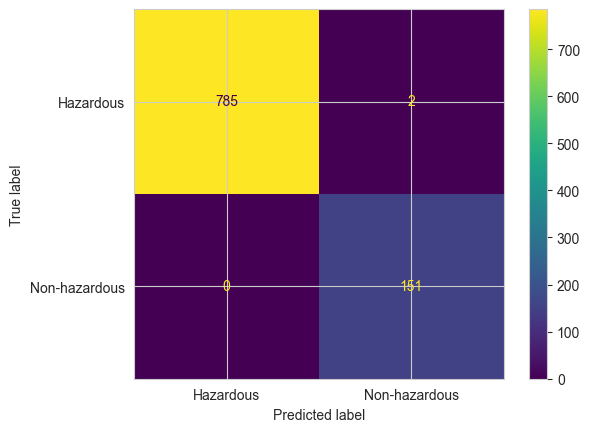

In [228]:
# earlier it was determined that the best hyperparameters for
# an RFC for the given task at hand were: 
# best_depth = rand_search.best_params_['max_depth']
# best_estimators = rand_search.best_params_['n_estimators']

best_depth = best_acc_max_depth
best_estimators = best_acc_n_estimators

# Create a model with these parameters
rf = RandomForestClassifier(n_estimators=best_depth, max_depth=best_estimators)

# train model
rf.fit(X_train_scaled, y_train)

# test
y_pred = rf.predict(X_test_scaled)

# accuracy, classification report, and confusion matrix
print(f"Accuracy = {accuracy_score(y_pred=y_pred, y_true=y_test)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hazardous", "Non-hazardous"]).plot()


In [148]:
# Let's take a look at what the model actually classifies as asteroid vs not an asteroid
# We'll do this by features. 

y_pred = pd.DataFrame(y_pred, columns=["Hazardous"])

copy_X_test_scaled = X_test_scaled
copy_X_test_scaled = pd.DataFrame(scaler.inverse_transform(copy_X_test_scaled), columns=copy_X_test_scaled.columns)
copy_X_test_scaled["Hazardous"] = y_pred
copy_X_test_scaled[copy_X_test_scaled["Hazardous"] == True]

,Absolute Magnitude,Eccentricity,Minimum Orbit Intersection,Orbit Uncertainity,Perihelion Distance,Relative Velocity km per hr,Hazardous
7,22.2,0.262599,0.002936,1.0,0.648673,48426.837172,True
14,20.9,0.127411,0.048253,0.0,1.046291,53988.552577,True
25,21.6,0.486207,0.021214,0.0,0.580610,52449.617663,True
29,21.0,0.533246,0.002155,2.0,0.771869,45660.404962,True
43,21.6,0.423314,0.040918,2.0,0.580992,37926.205292,True
...,...,...,...,...,...,...,...
911,18.4,0.354383,0.026241,0.0,0.793594,51487.766257,True
914,20.0,0.614610,0.014153,1.0,0.598010,58774.425578,True
921,20.9,0.626937,0.027105,1.0,0.961585,47806.370683,True
929,19.9,0.379769,0.013803,0.0,0.597207,75585.310236,True


After analysis of various model architectures available which seemed appropriate for the task at hand, it appears that the random forest classifier (RFC) slightly edges out the decision tree classifier (DTC) in terms of accuracy and overall performance. This model is thus to be saved as a file and kept for future purposes.

In [149]:
# This cell will save the best model (RFC) as a .pkl file
with open('RFC_Asteroids_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [137]:
# This cell is to load the model from the .pkl file
# and attempt to use it to make predictions
with open('RFC_Asteroids_model.pkl', 'rb') as file:
    loaded_rf = pickle.load(file)

user_asteroid = {}
for feature in X_train.columns:
    print(f"+======{feature}======+")
    print(f"- This feature varies from {round(min(clean_df[feature]), 3)} to {round(max(clean_df[feature]), 3)}")
    print(f"- On average, this feature has a value of {round(clean_df[feature].mean(), 3)}")
    user = input(f"Enter sample asteroid's {feature}: ")
    print(f"You entered: {user}\n")
    user_asteroid[feature] = float(user)

user_asteroid_df = pd.DataFrame(user_asteroid, index=[0])

scaled_user_asteroid_df = scaler.transform(user_asteroid_df)

scaled_user_asteroid_df = pd.DataFrame(scaled_user_asteroid_df, columns=user_asteroid_df.columns)

is_hazardous = loaded_rf.predict(scaled_user_asteroid_df)

if is_hazardous:
    print("Your inputted asteroid IS HAZARDOUS! TAKE COVERRRRRR")
else:
    print("Your inputted asteroid is NOT hazardous. Phew!")

+======Absolute Magnitude======+
- This feature varies from 11.16 to 32.1
- On average, this feature has a value of 22.268
You entered: 20
+======Eccentricity======+
- This feature varies from 0.008 to 0.96
- On average, this feature has a value of 0.383
You entered: 0.42
+======Minimum Orbit Intersection======+
- This feature varies from 0.0 to 0.478
- On average, this feature has a value of 0.082
You entered: 0.008
+======Orbit Uncertainity======+
- This feature varies from 0 to 9
- On average, this feature has a value of 3.517
You entered: 2.0
+======Perihelion Distance======+
- This feature varies from 0.081 to 1.3
- On average, this feature has a value of 0.813
You entered: 1.0
+======Relative Velocity km per hr======+
- This feature varies from 1207.815 to 160681.488
- On average, this feature has a value of 50294.92
You entered: 50823.1123
Your inputted asteroid IS HAZARDOUS! TAKE COVERRRRRR
